## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import json
import os
import random

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_probability as tfp
from celluloid import Camera
from matplotlib import pyplot as plt
from tensorflow import data, keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tqdm.notebook import tqdm, trange

# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

2023-01-31 16:16:13.330294: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

We will use the SMAP data sets for training and testing.

You can find raw data in https://s3-us-west-2.amazonaws.com/telemanom/data.ziphttps://s3-us-west-2.amazonaws.com/telemanom/data.zip

I used preprocessed datasets with 25 dimensions.

You can find preprocessed data in https://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRmhttps://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRm

In [2]:
train_dir = "./datasets/SMAP/SMAP_train.npy"
test_dir = "./datasets/SMAP/SMAP_test.npy"
test_label_dir = "./datasets/SMAP/SMAP_test_label.npy"

np_train = np.load(train_dir)
np_test = np.load(test_dir)
np_test_label = np.load(test_label_dir)


df_train = pd.DataFrame(data=np_train, columns=[f"feature_{i+1}" for i in range(np_train.shape[1])])
df_test = pd.DataFrame(data=np_test, columns=[f"feature_{i+1}" for i in range(np_test.shape[1])])
df_test_label = pd.DataFrame(data=np_test_label, columns=["label"])

## Quick look at the data

In [3]:
print(df_train.head())

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      0.999        0.0        0.0        0.0        0.0        0.0   
1      0.999        0.0        0.0        0.0        0.0        0.0   
2      0.999        0.0        0.0        0.0        0.0        0.0   
3      0.999        0.0        0.0        0.0        0.0        0.0   
4      0.999        0.0        0.0        0.0        0.0        0.0   

   feature_7  feature_8  feature_9  feature_10  ...  feature_16  feature_17  \
0        0.0        0.0        0.0         0.0  ...         0.0         0.0   
1        0.0        0.0        0.0         0.0  ...         0.0         0.0   
2        0.0        0.0        0.0         0.0  ...         0.0         0.0   
3        0.0        0.0        0.0         0.0  ...         0.0         0.0   
4        0.0        0.0        0.0         0.0  ...         0.0         0.0   

   feature_18  feature_19  feature_20  feature_21  feature_22  feature_23  \
0         0.0        

## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

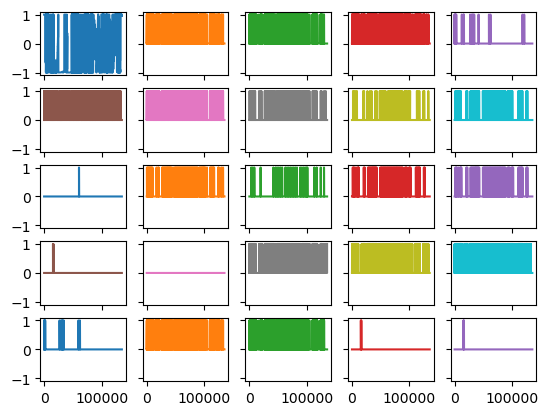

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
df_train.plot(legend=False, ax=ax, subplots=True)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

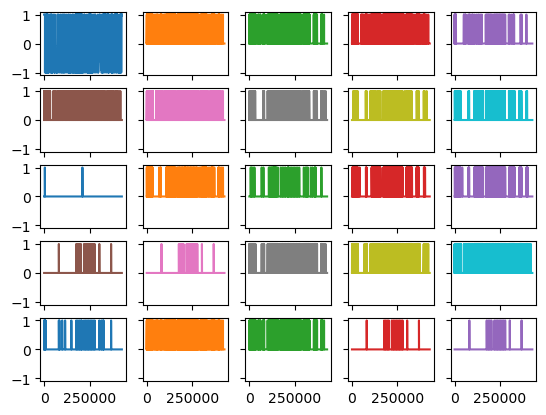

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
df_test.plot(legend=False, ax=ax, subplots=True)
plt.show()

## Prepare training data


In [6]:
from sklearn.preprocessing import StandardScaler

# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
print("Number of training samples:", len(df_training_value))

Number of training samples: 135183


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [15]:
TIME_STEPS = 1

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
NUM_OF_FEATURES = x_train.shape[-1]

Training input shape:  (135183, 1, 25)


## Build a model


In [16]:
class Sampling(layers.Layer):
    def __init__(self, name="sampling"):
        super(Sampling, self).__init__(name=name)

    def call(self, inputs):
        mu, logvar = inputs
        _, dim = mu.shape
        batch = 128
        sigma = K.exp(logvar * 0.5)
        epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)

        return mu + sigma * epsilon

In [17]:
class Encoder(layers.Layer):
    def __init__(self, time_step, x_dim, h_dim, z_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.encoder_inputs = keras.Input(shape=(time_step, x_dim))
        self.encoder_lstm = layers.LSTM(h_dim, activation="softplus", name="encoder_lstm")
        self.z_mean = layers.Dense(z_dim, name="z_mean")
        self.z_var = layers.Dense(z_dim, name="z_var")
        self.z_sample = Sampling()

    def call(self, inputs):
        print(inputs.shape)
        self.encoder_inputs = inputs  # (batch, time_steps, x_dim)
        hidden = self.encoder_lstm(self.encoder_inputs)  # (batch, h_dim)
        mu_z = self.z_mean(hidden)  # (batch, z_dim)
        logvar_z = self.z_var(hidden)  # (batch, z_dim)
        z = self.z_sample((mu_z, logvar_z))  # (batch, z_dim)

        return mu_z, logvar_z, z

In [18]:
class Decoder(layers.Layer):
    def __init__(self, time_step, x_dim, h_dim, z_dim, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.decoder_inputs = layers.RepeatVector(time_step, name="repeat_vector")
        self.decoder_lstm = layers.LSTM(
            h_dim, activation="softplus", name="decoder_lstm", return_sequences=True
        )
        self.x_mean = layers.Dense(x_dim, name="x_mean")
        self.x_sigma = layers.Dense(x_dim, name="x_sigma", activation="tanh")

    def call(self, inputs):
        z = self.decoder_inputs(inputs)  # (batch, time_step, z_dim)
        hidden = self.decoder_lstm(z)  # (batch, time_step, h_dim)
        mu_x = self.x_mean(hidden)  # (batch, time_step, x_dim)
        sigma_x = self.x_sigma(hidden)  # (batch, time_step, x_dim)

        return mu_x, sigma_x

In [19]:
loss_metric = keras.metrics.Mean(name="loss")
likelihood_metric = keras.metrics.Mean(name="log likelihood")


class LSTM_VAE(keras.Model):
    def __init__(self, time_step, x_dim, h_dim, z_dim, name="lstm_vae", **kwargs):
        super(LSTM_VAE, self).__init__(name=name, **kwargs)

        self.encoder = Encoder(time_step, x_dim, h_dim, z_dim, **kwargs)
        self.decoder = Decoder(time_step, x_dim, h_dim, z_dim, **kwargs)

    def call(self, inputs):
        mu_z, logvar_z, z = self.encoder(inputs)  # (batch, z_dim)
        mu_x, sigma_x = self.decoder(z)  # (batch, time_step, x_dim)

        var_z = K.exp(logvar_z)
        kl_loss = K.mean(-0.5 * K.sum(var_z - logvar_z + tf.square(1 - mu_z), axis=1), axis=0)
        self.add_loss(kl_loss)
        dist = tfp.distributions.Normal(loc=mu_x, scale=tf.abs(sigma_x))
        log_px = -dist.log_prob(inputs)  # (batch, time_step, x_dim)
        return mu_x, sigma_x, log_px

    def reconstruct_loss(self, x, mu_x, sigma_x):
        var_x = K.square(sigma_x)
        reconst_loss = -0.5 * K.sum(K.log(var_x), axis=2) + K.sum(
            K.square(x - mu_x) / var_x, axis=2
        )
        reconst_loss = K.reshape(reconst_loss, shape=(-1, 1))
        return K.mean(reconst_loss, axis=0)

    def mean_log_likelihood(self, log_px):
        log_px = K.reshape(log_px, shape=(log_px.shape[0], log_px.shape[2]))
        mean_log_px = K.mean(log_px, axis=1)
        return K.mean(mean_log_px, axis=0)

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        with tf.GradientTape() as tape:
            mu_x, sigma_x, log_px = self(x, training=True)
            loss = self.reconstruct_loss(x, mu_x, sigma_x)
            loss += sum(self.losses)
            mean_log_px = self.mean_log_likelihood(log_px)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        loss_metric.update_state(loss)
        likelihood_metric.update_state(mean_log_px)

        return {"loss": loss_metric.result(), "log_likelihood": likelihood_metric.result()}

In [20]:
time_step = TIME_STEPS
x_dim = x_train.shape[2]
h_dim = 32
z_dim = 16

X_train = x_train.astype('float32')
model = LSTM_VAE(time_step, x_dim, h_dim, z_dim, dtype="float32")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
train_dataset = data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128, drop_remainder=True)

history = model.fit(train_dataset, epochs=50, shuffle=False).history
model.summary()

Epoch 1/50


2023-01-31 16:16:54.699498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-31 16:16:54.739833: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz
2023-01-31 16:16:55.007498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  28/1056 [..............................] - ETA: 6s - loss: 68135877.4464 - log_likelihood: 1362716.9672

2023-01-31 16:16:55.693933: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-31 16:16:55.693985: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1056/1056 [==============================] - 9s 6ms/step - loss: -22700443.1755 - log_likelihood: 303906.6674
Epoch 2/50
1056/1056 [==============================] - 7s 6ms/step - loss: nan - log_likelihood: nan
Epoch 3/50
1056/1056 [==============================] - 7s 7ms/step - loss: nan - log_likelihood: nan
Epoch 4/50
1056/1056 [==============================] - 6s 6ms/step - loss: nan - log_likelihood: nan
Epoch 5/50
1056/1056 [==============================] - 7s 6ms/step - loss: nan - log_likelihood: nan
Epoch 6/50
1056/1056 [==============================] - 7s 7ms/step - loss: nan - log_likelihood: nan
Epoch 7/50
1056/1056 [==============================] - 7s 6ms/step - loss: nan - log_likelihood: nan
Epoch 8/50
1056/1056 [==============================] - 7s 6ms/step - loss: nan - log_likelihood: nan
Epoch 9/50
1056/1056 [==============================] - 6s 6ms/step - loss: nan - log_likelihood: nan
Epoch 10/50
1056/1056 [==============================] - 6s 6ms/step - los

KeyboardInterrupt: 

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

2023-01-26 13:34:49.553668: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-26 13:34:49.571758: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/50


2023-01-26 13:34:52.705936: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-26 13:34:53.439626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-01-26 13:34:53.669440: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-26 13:34:54.346530: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-26 13:34:54.346596: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


845/845 [==============================] - 22s 20ms/step - loss: 0.9471 - val_loss: 0.3751
Epoch 2/50
845/845 [==============================] - 16s 19ms/step - loss: 0.8931 - val_loss: 0.3547
Epoch 3/50
845/845 [==============================] - 16s 19ms/step - loss: 0.8705 - val_loss: 0.3462
Epoch 4/50
845/845 [==============================] - 18s 21ms/step - loss: 0.8546 - val_loss: 0.3397
Epoch 5/50
845/845 [==============================] - 18s 21ms/step - loss: 0.8437 - val_loss: 0.3336
Epoch 6/50
845/845 [==============================] - 16s 19ms/step - loss: 0.8354 - val_loss: 0.3310
Epoch 7/50
845/845 [==============================] - 16s 19ms/step - loss: 0.8288 - val_loss: 0.3276
Epoch 8/50
845/845 [==============================] - 17s 20ms/step - loss: 0.8239 - val_loss: 0.3254
Epoch 9/50
845/845 [==============================] - 19s 22ms/step - loss: 0.8192 - val_loss: 0.3230
Epoch 10/50
845/845 [==============================] - 19s 22ms/step - loss: 0.8164 - val_los

Let's plot training and validation loss to see how the training went.

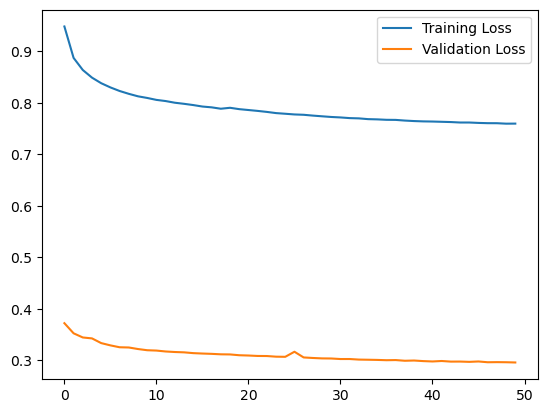

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


In [36]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# plt.hist(train_mae_loss, bins=50)
# plt.xlabel("Train MAE loss")
# plt.ylabel("No of samples")
# plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss, axis=0)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  [1.43624430e+00 1.58694973e+00 2.05328295e+00 1.24538812e+00
 5.01395440e+00 1.17538404e+00 1.11985111e+00 2.62221632e+00
 2.40974638e+00 1.00470474e+00 7.38731465e+00 2.64023806e+00
 3.84605512e+00 4.25130469e+00 4.25130462e+00 1.38568121e+01
 1.18877850e-15 1.50378792e+00 1.50980755e+00 1.26565242e+00
 2.24682395e+00 1.57828315e+00 1.48331472e+00 1.63985110e+01
 8.86768921e+00]


### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

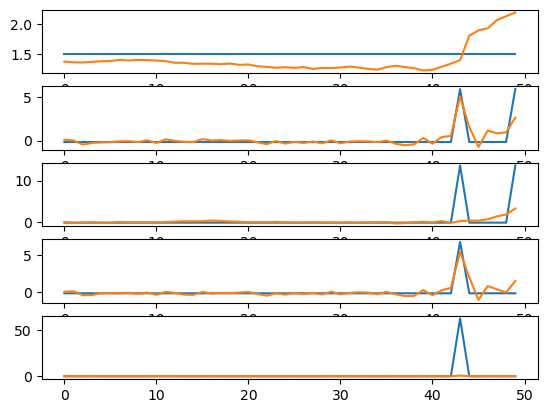

In [37]:
# Checking how the first sequence is learnt
for i in range(1, 6):
    ax = plt.subplot(5, 1, i)
    plt.plot(x_train[0, :, i - 1])
    plt.plot(x_train_pred[0, :, i - 1])

plt.show()

### Prepare test data

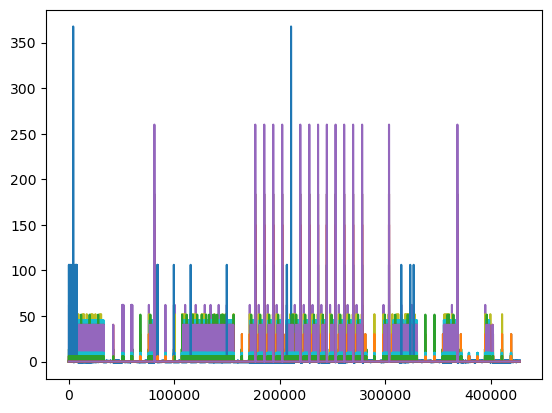

Test input shape:  (427568, 50, 25)


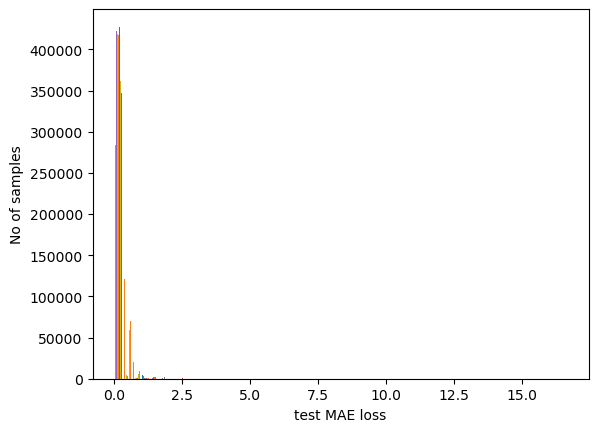

[[0.25444271 0.71848602 1.06309507 ... 0.65872801 0.02760493 0.02730904]
 [0.29326886 0.69074752 1.04196112 ... 0.64949283 0.02501328 0.01281857]
 [0.26863543 0.71927847 1.04098553 ... 0.68947533 0.03942398 0.02630595]
 ...
 [0.03257246 0.0211585  0.0068475  ... 0.01933362 0.01130774 0.01116526]
 [0.03240624 0.02112909 0.00681489 ... 0.01931997 0.01129981 0.01115286]
 [0.03205144 0.02112748 0.00688562 ... 0.01934943 0.01128007 0.01114308]] [1.43624430e+00 1.58694973e+00 2.05328295e+00 1.24538812e+00
 5.01395440e+00 1.17538404e+00 1.11985111e+00 2.62221632e+00
 2.40974638e+00 1.00470474e+00 7.38731465e+00 2.64023806e+00
 3.84605512e+00 4.25130469e+00 4.25130462e+00 1.38568121e+01
 1.18877850e-15 1.50378792e+00 1.50980755e+00 1.26565242e+00
 2.24682395e+00 1.57828315e+00 1.48331472e+00 1.63985110e+01
 8.86768921e+00]


In [38]:
df_test_value = pd.DataFrame(scaler.transform(df_test))
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
# test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label.values.tolist()
dates = df_test.index


np.sum(test_mae_loss, axis=1).plot(ax=ax)
ax.legend(["reconstruction error"], loc="upper right")

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if not temp_label:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if not temp_label:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")

In [54]:
# Detect all the samples which are anomalies.
# anomalies = test_mae_loss > threshold
print(np.sum(test_mae_loss, axis=1).shape, threshold.shape)
anomalies = np.sum(test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

(427568,) (25,)
Number of anomaly samples:  25
Indices of anomaly samples:  (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]),)


## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [33]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

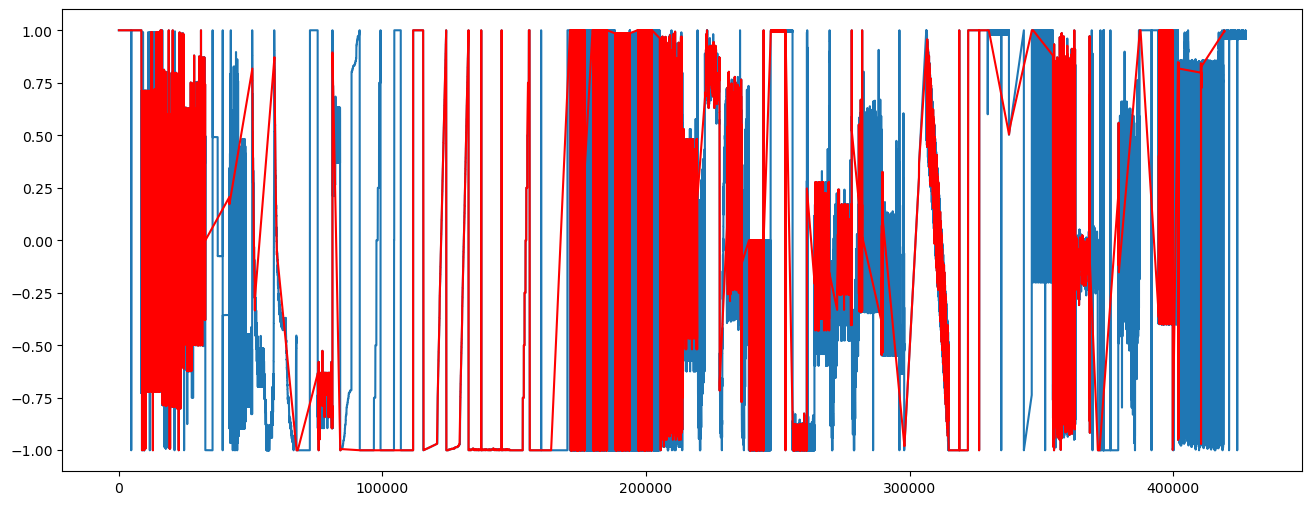

In [34]:
df_subset = df_test["feature_1"].iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(16, 6))
df_test["feature_1"].plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [35]:
from sklearn.metrics import classification_report

test_pred = np.zeros(len(df_test // 2))
test_label = df_test_label
test_pred[anomalous_data_indices] = 1

print(classification_report(test_label, test_pred))
# accuracy = (np.sum(test_pred == test_label)) / len(test_label) * 100
# precision = (np.sum(test_pred * test_label)) / np.sum(test_pred) * 100
# recall = (np.sum(test_pred * test_label)) / np.sum(test_label) * 100

# print(f"accuracy: {accuracy:.2f}%")
# print(f"precision: {precision:.2f}%")
# print(f"recall: {recall:.2f}%")

              precision    recall  f1-score   support

       False       0.86      0.83      0.84    372921
        True       0.07      0.10      0.08     54696

    accuracy                           0.73    427617
   macro avg       0.47      0.46      0.46    427617
weighted avg       0.76      0.73      0.75    427617

